In [23]:
import maboss
from tqdm import tqdm
import os
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
# Get the list of files in the model folder
model_folder = '/home/spankaew/Git/BooleanBenchmark/models/Invasion/'
model_files = os.listdir(model_folder)

model_logic = pd.DataFrame()

for i in model_files:
    logic = pd.read_csv(model_folder + i, index_col=0, header = None)
    logic.columns = [i.split('.')[0]]
    model_logic = pd.concat([model_logic, logic], axis = 1, ignore_index=False)
model_logic.index.name = None
model_logic = model_logic.transpose()

In [4]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from scipy.spatial.distance import pdist, squareform

# Sample DataFrame with categorical data
data = {
    'color': ['red', 'green', 'blue', 'green'],
    'shape': ['circle', 'triangle', 'square', 'circle'],
    'size': ['small', 'large', 'large', 'small']
}
df = pd.DataFrame(data)

# Step 1: One-hot encode the categorical data
encoder = OneHotEncoder()
encoded_data = encoder.fit_transform(df).toarray()
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out())
print("Encoded DataFrame:\n", encoded_df)

# Step 2: Calculate pairwise Hamming distances
distances = pdist(encoded_df, metric='hamming')
distance_matrix = squareform(distances)
print("Distance Matrix:\n", distance_matrix)

Encoded DataFrame:
    color_blue  color_green  color_red  shape_circle  shape_square  \
0         0.0          0.0        1.0           1.0           0.0   
1         0.0          1.0        0.0           0.0           0.0   
2         1.0          0.0        0.0           0.0           1.0   
3         0.0          1.0        0.0           1.0           0.0   

   shape_triangle  size_large  size_small  
0             0.0         0.0         1.0  
1             1.0         1.0         0.0  
2             0.0         1.0         0.0  
3             0.0         0.0         1.0  
Distance Matrix:
 [[0.   0.75 0.75 0.25]
 [0.75 0.   0.5  0.5 ]
 [0.75 0.5  0.   0.75]
 [0.25 0.5  0.75 0.  ]]


In [26]:
import numpy as np

# Calculate the weighted similarity distance
def weighted_similarity_distance(row1, row2, weights):
    similarity = row1 == row2
    similarity = similarity.replace({True :0,False:1})
    return np.sum(similarity*(weights))

# Convert distance matrix into lower triangle format for tree reconstruction
def to_lower_triangle(matrix):
    """
    Convert a square distance matrix to a lower triangle format.
    
    Args:
    matrix (np.array): A square numpy array representing the distance matrix.
    
    Returns:
    list: A list of lists representing the lower triangle of the distance matrix.
    """
    n = len(matrix)
    lower_triangle = []
    
    for i in range(n):
        row = []
        for j in range(i + 1):
            row.append(matrix[i][j])
        lower_triangle.append(row)
    
    return lower_triangle

In [27]:
# Create distance matrix from model_logic data
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder

# Ordinal encoding
encoder = OrdinalEncoder()
encoded_data = encoder.fit_transform(model_logic)
encoded_df = pd.DataFrame(encoded_data, columns=model_logic.columns)

# Calculate weights (inverse of the number of categories)
category_counts = model_logic.nunique()
weights = 1 / category_counts
weights_array = weights.values

# Create the distance matrix
num_samples = len(encoded_df)
distance_matrix = np.zeros((num_samples, num_samples))

# For loop to calculate the distances
for i in range(num_samples):
    for j in range(i + 1, num_samples):
        dist = weighted_similarity_distance(encoded_df.iloc[i], encoded_df.iloc[j], weights_array)
        distance_matrix[i, j] = dist
        distance_matrix[j, i] = dist

distance_matrix = pd.DataFrame(distance_matrix)
distance_matrix.to_csv('/home/spankaew/Git/BooleanBenchmark/tmp/InvasionModels_logic_distancemtx.csv')

In [31]:
model_labels = list(model_logic)

Index(['Invasion_532', 'Invasion_879', 'Invasion_718', 'Invasion_988',
       'Invasion_895', 'Invasion_855', 'Invasion_115', 'Invasion_263',
       'Invasion_210', 'Invasion_581',
       ...
       'Invasion_43', 'Invasion_193', 'Invasion_649', 'Invasion_741',
       'Invasion_391', 'Invasion_427', 'Invasion_571', 'Invasion_515',
       'Invasion_318', 'Invasion_799'],
      dtype='object', length=1024)

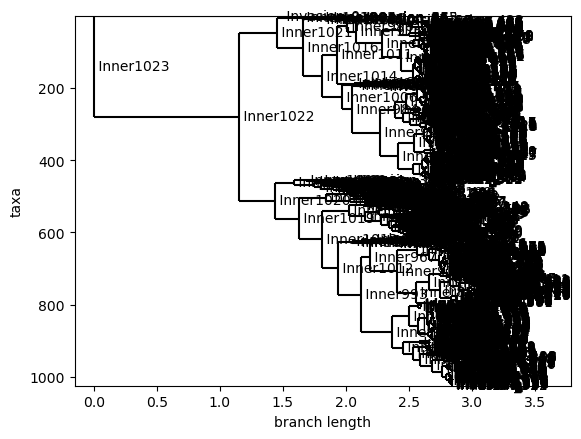

1

In [36]:
import numpy as np
import pandas as pd
import scipy
import Bio
from scipy.cluster.hierarchy import linkage, to_tree
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor, DistanceMatrix
from Bio import Phylo

# Define your distance matrix (example)
model_labels = list(model_logic.index)
distance_matrix = to_lower_triangle(distance_matrix)

# Convert the numpy array to a biopython DistanceMatrix
dm = DistanceMatrix(model_labels, matrix = distance_matrix)

# Use the DistanceTreeConstructor to construct the tree
constructor = DistanceTreeConstructor()
tree = constructor.upgma(dm)

# Draw the tree
Phylo.draw(tree)

# Print the tree in Newick format
Phylo.write(tree, "./test_phylogenetic_tree.newick", "newick")

Tree(rooted=True)